In [22]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -------------------------------
# 1. Synthetic Data Generator
# -------------------------------
def generate_damped_oscillator(num_samples=5000, seq_len=100, t_max=1.0):
    t = np.linspace(0, t_max, seq_len)
    embeddings = []
    signals = []

    for _ in range(num_samples):
        A = np.random.uniform(1.0, 2.0)       # amplitude
        f = np.random.uniform(1.0, 5.0)       # frequency
        phi = np.random.uniform(0, 2*np.pi)   # phase
        d = np.random.uniform(0.1, 1.0)       # damping
        x = np.tanh(A * np.exp(-d * t) * np.sin(2 * np.pi * f * t + phi))
        signals.append(x)
        embeddings.append([A, f, phi, d])

    X = np.array(signals, dtype=np.float32)
    y = np.array(embeddings, dtype=np.float32)
    return X, y



In [23]:
# -------------------------------
# 2. Dataset & Dataloader
# -------------------------------
X, y = generate_damped_oscillator(num_samples=5000)
X = torch.tensor(X).unsqueeze(-1)  # (N, seq_len, 1)
y = torch.tensor(y)                # (N, 4)

train_ds = TensorDataset(X, y)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)




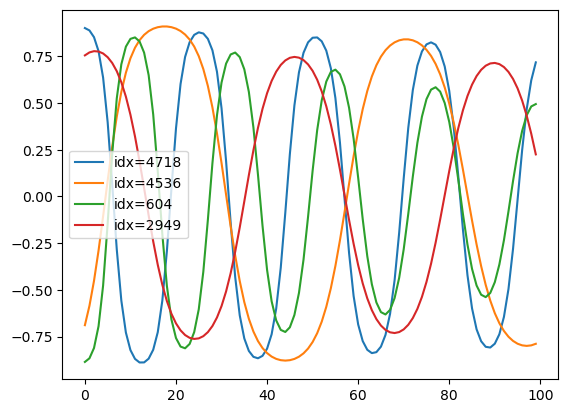

In [24]:
# Visualize some samples:

plt.figure()

for _ in range(4):
    idx = np.random.randint(0, len(X))
    plt.plot(range(100), X[idx], label=f'idx={idx}')
    

plt.legend()
plt.show()

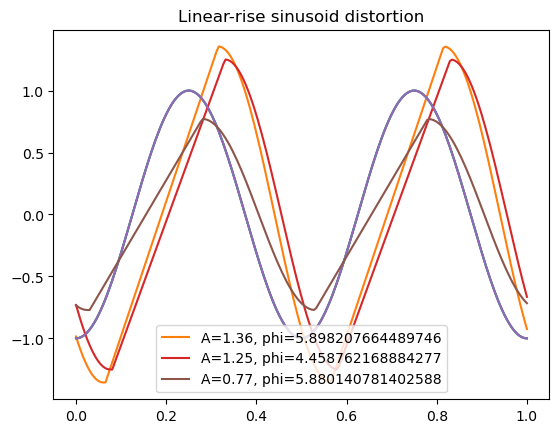

In [25]:


def linear_rise_sinusoid(num_samples=1000, seq_len=200, t_max=1.0):
    t = np.linspace(0, t_max, seq_len)
    originals, signals, embeddings = [], [], []

    for _ in range(num_samples):
        A = np.random.uniform(0.5, 1.5)       # amplitude
        f = 2. # np.random.uniform(1.0, 3.0)  # frequency / years
        phi = np.random.randint(0, 20)   # phase shift
        
        theta = 2*np.pi*f*t
        theta_mod = np.mod(theta, 2*np.pi)
        theta_shift = theta_mod - np.pi/2

        # custom shape: linear rise (0..π), sinusoidal fall (π..2π)
        shape = np.where(theta_mod < np.pi, 2*theta_shift/np.pi, np.sin(theta_shift))
        #shape = np.sin(theta)
        x = A * shape
        #x = theta_mod

        # rotate x:
        x = np.roll(x, phi)

        originals.append(np.sin(theta - np.pi/2))
        signals.append(x)
        embeddings.append([A, f, phi])
    
    return np.array(originals, dtype=np.float32), np.array(signals, dtype=np.float32), np.array(embeddings, dtype=np.float32), t

# Example visualization
at, wt, gt, t = linear_rise_sinusoid(num_samples=3)
for i in range(3):
    plt.plot(t, at[i])
    plt.plot(t, wt[i], label=f"A={gt[i,0]:.2f}, phi={y[i,2]}")
plt.title("Linear-rise sinusoid distortion")
plt.legend()
plt.show()


In [26]:
# -------------------------------
# 3. LSTM Model
# -------------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=3, output_dim=4):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        out = self.fc(h[-1])
        return out

model = LSTMRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [27]:
# -------------------------------
# 4. Training Loop
# -------------------------------
for epoch in range(5):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d}, Loss: {total_loss/len(train_loader):.6f}")

Epoch 01, Loss: 5.014417
Epoch 02, Loss: 1.200385
Epoch 03, Loss: 1.185453
Epoch 04, Loss: 1.184281
Epoch 05, Loss: 1.189667



True: [1.783 2.189 3.65  0.69 ]
Pred: [1.503 2.968 3.125 0.554]


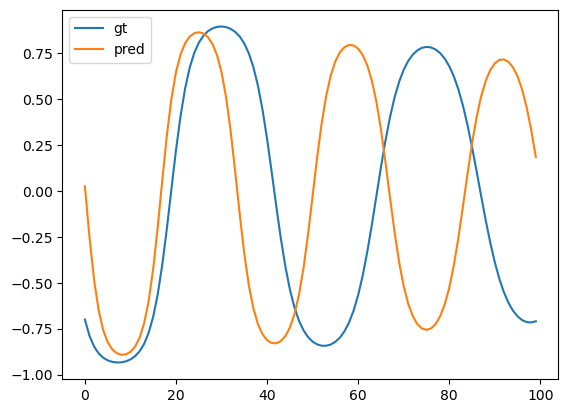

In [32]:
# -------------------------------
# 5. Quick Evaluation
# -------------------------------
model.eval()
with torch.no_grad():
    test_idx = np.random.randint(0, len(X))
    pred = model(X[test_idx].unsqueeze(0)).numpy().flatten()
    true = y[test_idx].numpy().flatten()
    print("\nTrue:", np.round(true, 3))
    print("Pred:", np.round(pred, 3))

    # predict:
    t = np.linspace(0, 1, 100)
    x_hat = np.tanh(pred[0] * np.exp(-pred[3] * t) * np.sin(2 * np.pi * pred[1] * t + pred[2]))

    plt.plot(range(100), X[test_idx], label='gt')
    plt.plot(range(100), x_hat, label='pred')
    plt.legend()
    plt.show()
